In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 16 10:22:29 2016
This is a Python program to extract resonator quality factor using nonlinear fit. 
The following libraries are adapted from the codes from qkitgroup : https://github.com/qkitgroup/qkit
*calibration.py
*circlefit.py
*circuit.py
*utilities.py
@author: Wenyuan Zhang , wzhang@physics.rutgers.edu
Modified to fit HFSS data output by Wen-Sen, wslu@gmail.com
"""
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as spopt
from scipy import stats
from circuit import *
from utilities import phase_vs_freq
from pprint import pprint
from copy import deepcopy

def loaddata(fname):
    df = pd.read_csv(fname)
    f     = df['Freq [GHz]'].to_numpy()
    mag   = df['mag(S(2,1)) []'].to_numpy()
    phase = df['ang_rad(S(2,1)) []'].to_numpy()
    S21 = mag*np.cos(phase)+1j*mag*np.sin(phase)
    return f, S21, df

def fr_Ql_init(f,S21):
    S21 = S21 / np.abs(S21)[0]
    S21_abs= np.abs(S21)
    S21_FWHM = 1/2*(np.min(S21_abs)**2+1)
#     print(S21_FWHM)
    fr_index = np.argmin(S21_abs)
    fr = f[fr_index]
    f_left = f[np.argmin(np.abs(S21_FWHM-S21_abs[0:fr_index]))]
    S21_left = S21_abs[np.argmin(np.abs(S21_FWHM-S21_abs[0:fr_index]))]
    f_right = f[fr_index+np.argmin(np.abs(S21_FWHM-S21_abs[fr_index:-1]))]
    S21_right = S21_abs[fr_index+np.argmin(np.abs(S21_FWHM-S21_abs[fr_index:-1]))]
    Ql = fr/(f_right-f_left)
    if False:
        plt.subplots()
        plt.title('init fr, Ql')
        plt.plot(f,S21_abs)
    S21_sim = (np.min(S21_abs)+2j*Ql*(1-f/fr))/(1+2j*Ql*(1-f/fr))
    if False:
        plt.plot(f,np.abs(S21_sim),f_left,S21_left,'o',f_right,S21_right,'o')
    return fr, Ql


In [3]:
def resFit(f,S21, verbose = False, REMOVE_BACKGND = False):
    angles=np.linspace(0,2*np.pi,2000)
    port = notch_port(f,S21)

    if False:
        index=np.arange(580,802)
        f_data_origin=f[index]
        z_data_origin=S21[index]
    else:
        f_data_origin=f
        z_data_origin=S21
    
    f_data=f_data_origin
    z_data=z_data_origin

    if verbose:
        plt.subplots(2,1)
        plt.suptitle('Raw data')
        plt.subplot(211)
        plt.plot(f_data,np.abs(z_data),'+-')
        plt.subplot(212)
        plt.plot(f_data,np.angle(z_data),'+-')

    if REMOVE_BACKGND:
        linear_var = -22
        z_data = z_data/(1+linear_var*(f_data/frcal-1)) 
    else: 
        linear_var = 0
    
    delay = port._guess_delay(f_data,z_data)
    delay = port._fit_delay(f_data,z_data,delay,maxiter=200)
    A1, A2, A3, A4, frcal, Ql=port._fit_skewed_lorentzian(f_data,z_data)
    z_data = z_data_origin*np.exp(2.*1j*np.pi*delay*f_data)
    
    if REMOVE_BACKGND:
        plt.subplots()
        plt.title('|S21| before and after background slope removed')
        plt.plot(f_data_origin,np.absolute(z_data_origin),'+')
        plt.plot(f_data,np.absolute(z_data),'.')

    xc, yc, r0 = port._fit_circle(z_data,refine_results=True)

    [plt.subplots() for _ in [1] if verbose]
    [plt.plot(np.real(z_data),np.imag(z_data),'.') for _ in [1] if verbose]
    [plt.title('circle fit') for _ in [1] if verbose]
    xc, yc, r0 = port._fit_circle(z_data,refine_results=True)
    [plt.plot(xc+r0*np.cos(angles),yc+r0*np.sin(angles)) for _ in [1] if verbose]
## 
    zc = np.complex(xc,yc)
    theta = np.angle(port._center(z_data,zc))[np.argmin(f_data-frcal)]
    theta=-4
    fitparams = port._phase_fit(f_data,port._center(z_data,zc),theta,np.absolute(Ql),frcal)
    theta, Ql, fr = fitparams
    [plt.subplots() for _ in [1] if verbose]
    [plt.title('phase fit before after') for _ in [1] if verbose]
    _phase = np.angle(port._center(z_data,zc)) 
    [plt.plot(f_data,np.unwrap(_phase),'.') for _ in [1] if verbose]

    if Ql<0:
        raise('Ql is less than zero')
    _phase = theta+2.*np.arctan(2.*Ql*(1.-f_data/fr))
    [plt.plot(f_data, _phase) for _ in [1] if verbose]
    beta = theta + np.pi
    offrespoint = np.complex((xc+r0*np.cos(beta)),(yc+r0*np.sin(beta)))
    alpha = np.angle(offrespoint)
    a = np.absolute(offrespoint)
    if verbose:
        plt.subplots()
        plt.title('off res point')
        plt.plot(np.real(z_data),np.imag(z_data),'.-')
        plt.plot(xc+r0*np.cos(angles),yc+r0*np.sin(angles))
        plt.plot(offrespoint.real,offrespoint.imag,'o')
    # normalize 
    z_data = z_data/a*np.exp(1j*(-alpha))
    if verbose:
        plt.subplots()
        plt.title('after normalization')
        plt.plot(z_data.real,z_data.imag,'.')
        plt.xlim(-2,2)
        plt.ylim(-2,2)
    
    port.fitresults = port.circlefit(f_data,z_data,fr,Ql,refine_results=True,calc_errors=True,m=20)
    
    z_data_sim = port._S21_notch(f_data,fr=port.fitresults["fr"],Ql=port.fitresults["Ql"],Qc=port.fitresults["absQc"],phi=port.fitresults["phi0"],a=a,alpha=alpha,delay=delay) * (1+linear_var*(f_data/port.fitresults["fr"]-1))
    
    if verbose:
        plt.subplots(2,1)
        plt.subplot(2,1,1)
        plt.title('raw data vs simulated data, Mag')
        plt.plot(f_data_origin,np.abs(z_data_origin),'+')
        plt.plot(f_data,np.abs(z_data_sim))
        plt.subplot(2,1,2)
        plt.title('raw data vs simulated data, phase')
        plt.plot(f_data_origin,np.angle(z_data_origin),'+')
        plt.plot(f_data,np.angle(z_data_sim))
    
    results = np.array([
                        port.fitresults['fr'],
                        port.fitresults['Qi_dia_corr'],
                        port.fitresults['Qi_dia_corr_err'],
                        port.fitresults['Qi_no_corr'],
                        port.fitresults['Qi_no_corr_err'],
                        port.fitresults['absQc'],
                        port.fitresults['absQc_err'],
                        port.fitresults['Qc_dia_corr'],
                        port.fitresults['Ql'],
                        port.fitresults['Ql_err'],
                        port.fitresults['chi_square_'],
                        delay,
                        a,
                        port.fitresults['Qc_dia_corr_err']
                      ])
    results = np.reshape(results,(1,results.size))
    [print('===========Results===========') for _ in [1] if verbose]
    [pprint(port.fitresults) for _ in [1] if verbose]
    
    [print('average number of photons in resonator at -130dBm input power', port.get_photons_in_resonator(-130)) for _ in [1] if verbose]
    [print('single photon limit power at input port(dBm)',port.get_single_photon_limit()) for _ in [1] if verbose]

    return port.fitresults['Ql'], port.fitresults['Qi_dia_corr'], port.fitresults['Qc_dia_corr']

In [3]:
%matplotlib notebook
Qdic = {'G_CP [um]': 0, 'L_CP [um]': 0, 'Ql':0, 'Qi':0, 'Qc':0}
dfR = pd.DataFrame(data = Qdic, index = [0])

<IPython.core.display.Javascript object>


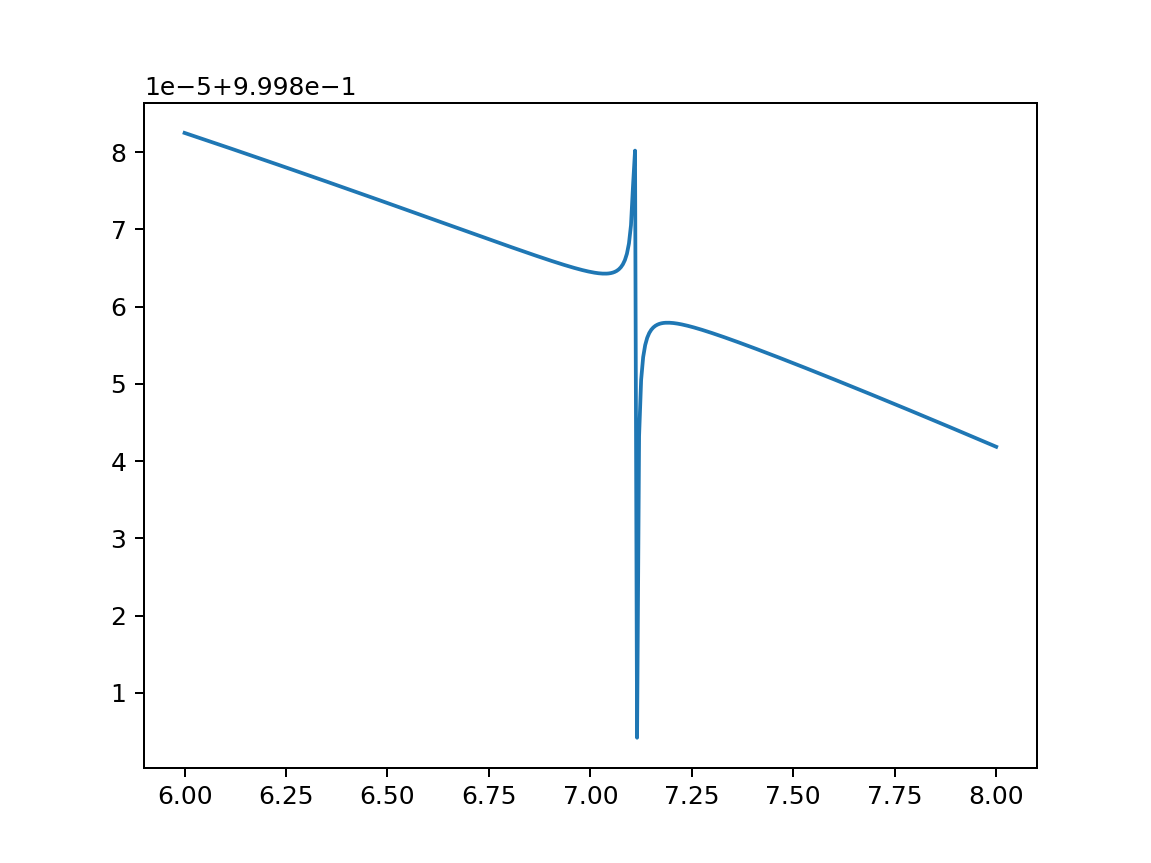

In [4]:
_, _, dfl = loaddata(r'rawdata\JJRO_wiGND20len\GND.csv')


dflst = []
for i in range(dfl.shape[0]//401):
    dflst += [dfl.iloc[401*i:401*(i+1)]]
    
df = dflst[0]
f     = df['Freq [GHz]'].to_numpy()
mag   = df['mag(S(2,1)) []'].to_numpy()
phase = df['ang_rad(S(2,1)) []'].to_numpy()
plt.plot(f,mag)

In [4]:
def Ql3dBest(dfraw):
    dfraw = dfraw[dfraw['mag(S(2,1)) []'] < (1/np.sqrt(2)) ]
    f   = dfraw['Freq [GHz]'].to_numpy()
    mag = dfraw['mag(S(2,1)) []']

    QcoQi = mag.min()/mag.max()
    print('This estimation works only when: Qc/(Qc+Qi) < {:.2%}'.format(QcoQi))
    fvalley = dfraw[mag == mag.min()]['Freq [GHz]'].iloc[0]
    return([fvalley/(f[-1]-f[0]), QcoQi, fvalley])

In [6]:
folder = r'rawdata\JJRO_woGND200len'
Qllst = []
for l in os.listdir(folder)[:7]:
    _, _, dfraw = loaddata('rawdata\JJRO_woGND200len\\'+l)
    lst = Ql3dBest(dfraw)
    lst2 = [lst[0], lst[2]]
    lst2.insert(-1,lst[-3]/lst[-2])    
    lst2.insert(-1,lst[-3])
    lst2.insert(0,int(folder[18:-3]))
    lst2.insert(0,int(l[:-14]))
    print(lst)
    Qllst += [lst2]
dfEst = pd.DataFrame(data = Qllst, columns = ['G_CP [um]', 'L_CP [um]', 'Ql', 'Qi_min', 'Qc', 'f_res [GHz]'])
dfEst = dfEst.sort_values(by = 'G_CP [um]', axis = 0).reset_index().drop(labels='index', axis=1)
# dfEst.to_csv('3dBEst.csv')

This estimation works only when: Qc/(Qc+Qi) < 2.21%
[10169.178571426466, 0.022076044911153288, 7.118425]
This estimation works only when: Qc/(Qc+Qi) < 0.00%
[12161.01709399743, 1.1797343367034667e-05, 7.114195]
This estimation works only when: Qc/(Qc+Qi) < 1.36%
[3035.7721925141, 0.013558563741755288, 7.0961175]
This estimation works only when: Qc/(Qc+Qi) < 3.11%
[14390.38383838639, 0.031090444567157167, 7.123239999999999]
This estimation works only when: Qc/(Qc+Qi) < 1.02%
[15794.472222196686, 0.01018655182981317, 7.1075125]
This estimation works only when: Qc/(Qc+Qi) < 2.19%
[17261.242424226904, 0.021916146613785586, 7.1202625]
This estimation works only when: Qc/(Qc+Qi) < 2.28%
[7248.380102052454, 0.022797647509200467, 7.1034125]


In [34]:
pd.read_csv('3dBEst.csv')

,Unnamed: 0,G_CP [um],L_CP [um],Ql,Qi_min,Qc,f_res [GHz]
0,0,1,200,3035.772193,2.239007e+05,3035.772193,7.096118
1,1,6,200,7248.380102,3.179442e+05,7248.380102,7.103413
2,2,11,200,10169.178571,4.606431e+05,10169.178571,7.118425
3,3,16,200,12161.017094,1.030827e+09,12161.017094,7.114195
4,4,21,200,14390.383838,4.628555e+05,14390.383838,7.123240
5,5,26,200,15794.472222,1.550522e+06,15794.472222,7.107513
6,6,31,200,17261.242424,7.876039e+05,17261.242424,7.120262


In [33]:
pd.read_csv('3dBEst_GND.csv')

,Unnamed: 0,G_CP [um],L_CP [um],Ql,Qi_min,Qc,f_res [GHz]
0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,17.0,120.0,576943.2429,1.879367e+07,576943.2429,7.115633
2,2,27.0,120.0,713517.4670,1.936255e+08,713517.4670,7.135472
3,3,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN,NaN,NaN


In [323]:
dfR
dfR.drop([0]).to_csv('circFit.csv')

In [29]:
_, _, dfraw = loaddata(r'rawdata\JJRO_wiGND20len\GND_EX200_L200G22.csv')
lst = Ql3dBest(dfraw)
print(lst)
lst[-3]/lst[-2]

This estimation works only when: Qc/(Qc+Qi) < 0.03%
[120667.81324213931, 0.0003228268544032765, 7.06208377]


373784930.20720214

agebraic r0: 0.4998774302689773
iterative r0: 0.49987743026897313
agebraic r0: 0.4998774302689773
iterative r0: 0.49987743026897313
agebraic r0: 0.5000006604290256
iterative r0: 0.5000006604290219


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 200.
  warnings.warn(errors[info][0], RuntimeWarning)


{'G_CP [um]': 22,
 'L_CP [um]': 200,
 'Ql': 120298.63211568777,
 'Qi': 4546915141195.509,
 'Qc': 120298.63529845254}

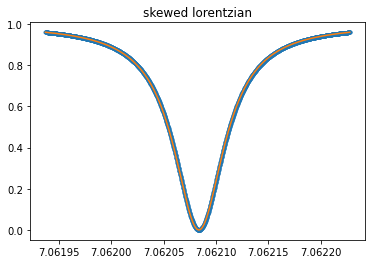

In [28]:
_, _, dfraw = loaddata(r'rawdata\JJRO_wiGND20len\GND_EX200_L200G22.csv')
dfl = [dfraw[dfraw['mag(S(2,1)) []']<0.98]]

for d in dfl:
    f     = d['Freq [GHz]'].to_numpy()
    mag   = d['mag(S(2,1)) []'].to_numpy()
    phase = d['ang_rad(S(2,1)) []'].to_numpy()
    S21 = mag*np.cos(phase)+1j*mag*np.sin(phase)
    Ql, Qi, Qc = resFit(f, S21, verbose = False)
    s = d[['G_CP [um]', 'L_CP [um]']].iloc[0]
    Qdic = {'G_CP [um]': s[0], 'L_CP [um]': s[1], 'Ql':Ql, 'Qi':Qi, 'Qc':Qc}
#     dfR = dfR.append(Qdic, ignore_index = True)
Qdic

agebraic r0: 0.4998774302689773
iterative r0: 0.49987743026897313
agebraic r0: 0.4998774302689773
iterative r0: 0.49987743026897313
agebraic r0: 0.5000006604290256
iterative r0: 0.5000006604290219


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 200.
  warnings.warn(errors[info][0], RuntimeWarning)


{'G_CP [um]': 22,
 'L_CP [um]': 200,
 'Ql': 120298.63211568777,
 'Qi': 4546915141195.509,
 'Qc': 120298.63529845254}

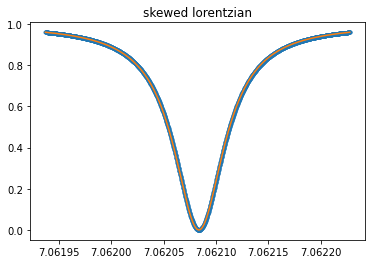

In [27]:
_, _, dfraw = loaddata(r'rawdata\JJRO_wiGND20len\GND_EX200_L200G22.csv')
dfl = [dfraw[dfraw['mag(S(2,1)) []']<0.98]]

for d in dfl:
    f     = d['Freq [GHz]'].to_numpy()
    mag   = d['mag(S(2,1)) []'].to_numpy()
    phase = d['ang_rad(S(2,1)) []'].to_numpy()
    S21 = mag*np.cos(phase)+1j*mag*np.sin(phase)
    Ql, Qi, Qc = resFit(f, S21, verbose = False)
    s = d[['G_CP [um]', 'L_CP [um]']].iloc[0]
    Qdic = {'G_CP [um]': s[0], 'L_CP [um]': s[1], 'Ql':Ql, 'Qi':Qi, 'Qc':Qc}
#     dfR = dfR.append(Qdic, ignore_index = True)
Qdic

## Comparison

<IPython.core.display.Javascript object>


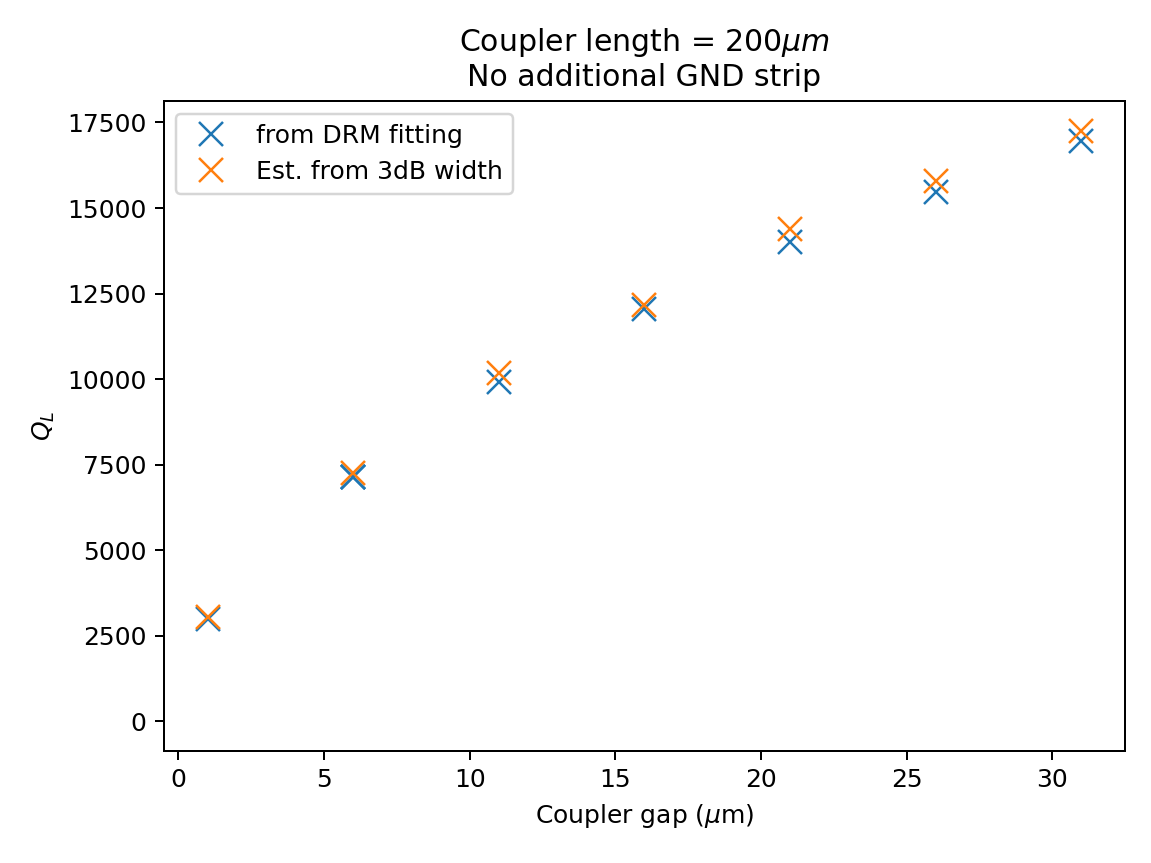

In [11]:
dfRp   = pd.read_csv('circFit.csv')
dfEstp = pd.read_csv('3dBEst.csv')

fig,ax = plt.subplots()
ax.plot(dfRp['G_CP [um]'], dfRp['Ql'], 'x', ms = 10, ls = 'none', label = 'from DRM fitting')
ax.plot(dfEstp['G_CP [um]'], dfEstp['Ql'], 'x', ms = 10, ls = 'none', label = 'Est. from 3dB width')
ax.set_title('Coupler length = 200$\mu m$\nNo additional GND strip')
ax.set_xlabel('Coupler gap ($\mu$m)')
ax.set_ylabel('$Q_L$')
ax.legend()
plt.tight_layout()

In [86]:
dfr

,G_CP [um],L_CP [um],Ql,Qi,Qc
0,0.0,0.0,0.000000,0.000000e+00,0.000000
1,6.0,200.0,7147.685902,-3.084426e+11,7147.685736
2,6.0,200.0,7151.841959,8.413333e+07,7152.449961


In [107]:
dfR

,G_CP [um],L_CP [um],Ql,Qi,Qc
0,0.0,0.0,0.000000,0.000000e+00,0.000000
1,6.0,200.0,7147.685902,-3.084426e+11,7147.685736
2,6.0,200.0,7151.841959,8.413333e+07,7152.449961
3,1.0,200.0,2980.531223,-7.793467e+11,2980.531211
4,6.0,200.0,7147.683720,-3.089255e+11,7147.683554
5,11.0,200.0,9923.544597,1.764261e+11,9923.545155
6,16.0,200.0,12062.233159,7.732120e+09,12062.251976
7,21.0,200.0,14022.195523,1.095713e+11,14022.197317
8,26.0,200.0,15471.460834,-2.306702e+10,15471.450457
9,31.0,200.0,16964.019207,3.210962e+10,16964.028170
